# Import Libraries

In [1]:
from google.colab import drive
#drive.mount('/content/gdrive/')
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd "/content/gdrive/My Drive/Colab Notebooks/LADMM_Net_Pytorch"
%ls

/content/gdrive/My Drive/Colab Notebooks/LADMM_Net_Pytorch
calib32.mat                           psnr_vs_epochs_layer_7_ratio_25.mat
data/                                 TrainHarvardDataset.ipynb
FusionTestHarvard.ipynb               train_parameters/
models/                               utils/
psnr_vs_epochs_layer_10_ratio_25.mat  xyz.mat
psnr_vs_epochs_layer_5_ratio_25.mat


In [3]:
import os
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import scipy.io as sio

# our libraries
from utils import featurefusionpkg as ff

from skimage.metrics import structural_similarity as ssim

from models.LadmmNet import LADMMcsifusionfastNet
# Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

gpu_list = '0'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_list
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Measurement Matrices

In [4]:
# Loading hyperspectral coded aperture
fname1       = 'cca_hs.mat'
data_path    = os.path.join(os.getcwd(),'data/Harvard/csi_measurements/25')
#data_path    = os.path.join(os.getcwd(),'data/Harvard/csi_measurements/375')
cca_hs       = sio.loadmat(os.path.join(data_path, fname1))['cca_hs']
shots_hs, M_hs, N_hs, L = cca_hs.shape
ccahs_np     = np.zeros((shots_hs*M_hs*N_hs*L))
for i in range(0,shots_hs):
  ccahs_np[i*M_hs*N_hs*L:(i+1)*M_hs*N_hs*L] = cca_hs[i,:,:,:].reshape((M_hs*N_hs*L),order='F')
ccahs        = torch.from_numpy(np.double(ccahs_np)).type(torch.FloatTensor)
del cca_hs, ccahs_np
ccahs = ccahs.view(-1,L,M_hs,N_hs).to(device)

# Loading multispectral coded aperture
fname1       = 'cca_ms.mat'
cca_ms       = sio.loadmat(os.path.join(data_path, fname1))['cca_ms']
shots_ms, M, N, L_ms = cca_ms.shape
ccams_np     = np.zeros((shots_ms*M*N*L_ms))
for i in range(0,shots_ms):
  ccams_np[i*M*N*L_ms:(i+1)*M*N*L_ms] = cca_ms[i,:,:,:].reshape((M*N*L_ms),order='F')
ccams        = torch.from_numpy(np.double(ccams_np)).type(torch.FloatTensor)
del cca_ms, ccams_np
ccams = ccams.view(-1,L_ms,M,N).to(device)

p = 4
q = 2

# LADMM Parameters

Text(240, 495, 'PSNR: 39.46 dB')

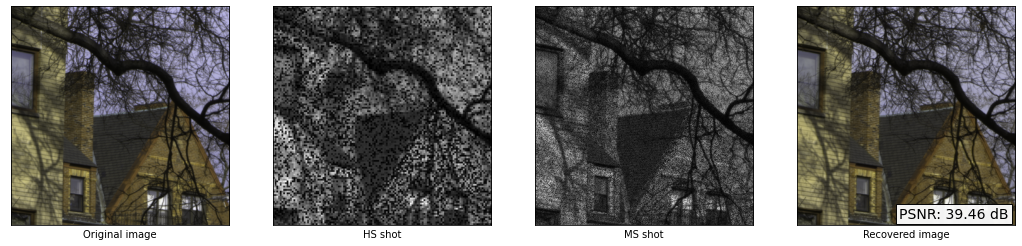

In [5]:
layer_num               = 10
learning_rate           = 0.0005
epochs                  = 256
epochs                  = epochs + 1
num_training_samples    = 48
num_samples             = 48
batch_size              = 1
compression_ratio       = 25

model = LADMMcsifusionfastNet(layer_num)
model = nn.DataParallel(model)
model= model.to(device)

print_flag = 0
if print_flag:
    num_count = 0
    for para in model.parameters():
        num_count += 1
        print('Layer %d' % num_count)
        print(para.size())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

data_path       = os.path.join(os.getcwd(),'data/Harvard/test_images_to_show')
model_dir       = "./train_parameters/Harvard/LADMM_Net_layer_%d_ratio_%d" % (layer_num, compression_ratio)
model.load_state_dict(torch.load('./%s/net_params_%d.pkl' % (model_dir, epochs-1),map_location='cpu'))
model= model.to(device)

def SpectralDegradationFilter(window_size, L, q):
  kernel = torch.zeros((L//q,L,window_size,window_size))
  for i in range(0,L//q):
    kernel[i,i*q:(i+1)*(q),window_size//2,window_size//2] = 1/q
  return kernel

def ProjectionFilter(window_size, L):
  kernel = torch.zeros((1,L,window_size,window_size))
  kernel[0,1:L,window_size//2,window_size//2] = 1
  return kernel

def SpectralUpsamplingFilter(window_size, q, L):
  kernel = torch.zeros((L,L//q,window_size,window_size))
  for i in range(0,L//q):
    for j in range(0,q):
      kernel[i*q+j,i,window_size//2,window_size//2] = 1 
  return kernel

fnp = np.zeros((M*N*L*batch_size))
# Houses
new_indices = 60 

# Cork wall
#new_indices = 111

# Door
#new_indices = 135
fpointer        = new_indices + 1
fsamples_ms     = 'hri_%03d.mat' % (fpointer)
hri             = sio.loadmat(os.path.join(data_path, fsamples_ms))['foo']
fnp[0:M*N*L] = hri.reshape((M*N*L),order='F')

f = torch.from_numpy(np.double(fnp)).type(torch.FloatTensor)*(1/255.0)
f = f.view(-1,L,M,N).to(device)

# Acquisition process of the HS compressive measurements
hs_deg        = nn.AvgPool2d(p)
shot_data_hs  = torch.mean(torch.mul(ccahs,hs_deg(f).repeat(shots_hs, 1, 1, 1)),(1))
shot_data_hs  = shot_data_hs * (1/torch.max(shot_data_hs)) 

# HS measurement matrix transpose
HTyhs         = F.interpolate(torch.mean(torch.mul(shot_data_hs.view(shots_hs,1,M_hs,N_hs).repeat(1,L,1,1), ccahs),(0)).view(1,L,M_hs,N_hs),scale_factor=(p,p))

# Acquisition process of the MS compressive measurements
kernel = SpectralDegradationFilter(3,L,q).to(device)
shot_data_ms  = torch.mean(torch.mul(ccams,F.conv2d(f, kernel, padding=1).repeat(shots_ms, 1, 1, 1)),(1))
shot_data_ms  = shot_data_ms * (1/torch.max(shot_data_ms))

# MS measurement matrix transpose
upsamp = SpectralUpsamplingFilter(3,q,L_ms*q).to(device)
HTyms  = F.conv2d(torch.mean(torch.mul(shot_data_ms.view(shots_ms,1,M,N).repeat(1,L_ms,1,1), ccams),(0)).view(1,L_ms,M,N),upsamp, padding=1)

[x_output, loss_layers_sym] = model(ccahs, ccams, HTyhs, HTyms, M, N, L, p, q, shots_hs, shots_ms)

hri = hri / np.max(hri)

Io        = np.zeros((M,N,L))
sd_hs     = np.zeros((M//p,N//p,shots_hs))
sd_ms     = np.zeros((M,N,shots_ms))

psnr_rec  = np.zeros(L)
ssim_rec  = np.zeros(L)
for l in range(0,L):
    It1         = x_output.view(-1,32,512,512)[0,l,:,:]
    It1         = It1.cpu().detach().numpy()
    Io[:,:,l]   = np.transpose(It1)
    It2         = np.transpose(hri[:,:,l])
    res         = np.mean(np.power((It2-It1),2))
    psnr_rec[l]   = 10*np.log10(1/res)
    ssim_rec[l]   = ssim(It2, It1, data_range=1)

# Measurements
for l in range(0,shots_hs):
    It3         = shot_data_hs.view(-1,shots_hs,M//p,N//p)[0,l,:,:]
    It3         = It3.cpu().detach().numpy()
    sd_hs[:,:,l]= np.transpose(It3)

for l in range(0,shots_ms):
    It4         = shot_data_ms.view(-1,shots_ms,M,N)[0,l,:,:]
    It4         = It4.cpu().detach().numpy()
    sd_ms[:,:,l]= np.transpose(It4)

psnr = np.mean(psnr_rec)
ssim = np.mean(ssim_rec)
#print(psnr, ssim)

# RGB composite of the original image
I0 = np.zeros((M,N,3))
Ix = np.zeros((M,N,L))
calib32 = sio.loadmat('calib32.mat')['calib32']
xyz     = sio.loadmat('xyz.mat')['xyz']
for l in range(0,L):
    scale = 1.0 / calib32[0,l] 
    Ix[:,:,l] = np.multiply(scale, hri[:,:,l])
    maxIx = np.max(Ix[:,:,l])
    Ix[:,:,l] = Ix[:,:,l] / maxIx
    
for k in range(0,3):
    Ixx = np.zeros((M,N))
    for l in range(0,L):
        scale = xyz[l,k] 
        Ixx = Ixx + np.multiply(scale, Ix[:,:,l])
    maxIxx = np.max(Ixx)
    I0[:,:,k] = Ixx / maxIxx

# RGB composite of the recovered image
I1 = np.zeros((M,N,3))
Ix = np.zeros((M,N,L))
for l in range(0,L):
    scale = 1.0 / calib32[0,l] 
    Ix[:,:,l] = np.multiply(scale, Io[:,:,l])
    maxIx = np.max(Ix[:,:,l])
    Ix[:,:,l] = Ix[:,:,l] / maxIx
    
for k in range(0,3):
    Ixx = np.zeros((M,N))
    for l in range(0,L):
        scale = xyz[l,k] 
        Ixx = Ixx + np.multiply(scale, Ix[:,:,l])
    maxIxx = np.max(Ixx)
    I1[:,:,k] = Ixx / maxIxx

plt.figure(figsize=(18,8))

plt.subplot(1,4,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(I0)
plt.xlabel('Original image')

plt.subplot(1,4,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(sd_hs[:,:,0],cmap='gray')
plt.xlabel('HS shot')

plt.subplot(1,4,3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(sd_ms[:,:,0],cmap='gray')
plt.xlabel('MS shot')

plt.subplot(1,4,4)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(I1)
plt.xlabel('Recovered image')
plt.text(240, 495, 'PSNR: %.2f dB'%(psnr), fontsize=14,
        bbox={'facecolor': 'white', 'alpha': 0.95, 'pad': 3})
#plt.savefig('recover1_im3.eps', format='eps', bbox_inches = 'tight', pad_inches = 0)